# Sound Road Classificator
## Algorythm to classification of sound using RNN
This algorythom is based in Tensorflow and Librosa

## System and Libraries

## Train model

### Import libraries 

In [1]:
import glob
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
import numpy as np


In [2]:
%matplotlib inline
plt.style.use('ggplot')

### Training variables

For complete training on server we used 10000 iterations(training_iters)

In [3]:
tf.reset_default_graph()

learning_rate = 0.01
training_iters = 500
#training_iters = 10000
batch_size = 50
display_step = 200

# Network Parameters
n_input = 50 
n_steps = 50
n_hidden = 300
n_classes = 2 

x = tf.placeholder("float", [None, n_input, n_steps])
y = tf.placeholder("float", [None, n_classes])

weight = tf.Variable(tf.random_normal([n_hidden, n_classes]))
bias = tf.Variable(tf.random_normal([n_classes]))

### Load data functions

In [4]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)

def extract_features(parent_dir,sub_dirs,file_ext="*.flac",bands = 50, frames = 100):
    window_size = 512 * (frames - 1)
    mfccs = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            label = fn.split('/')[2].split('-')[1]
            for (start,end) in windows(sound_clip,window_size):
                tmp_clip = sound_clip[int(start):int(end)]
                if len(tmp_clip) == window_size:
                    signal = tmp_clip
                    mfcc = librosa.feature.mfcc(y=signal, sr=s, n_mfcc = bands).T.flatten()[:, np.newaxis].T
                    mfccs.append(mfcc)
                    labels.append(label)         
    features = np.asarray(mfccs).reshape(len(mfccs),bands,frames)
    return np.array(features), np.array(labels,dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

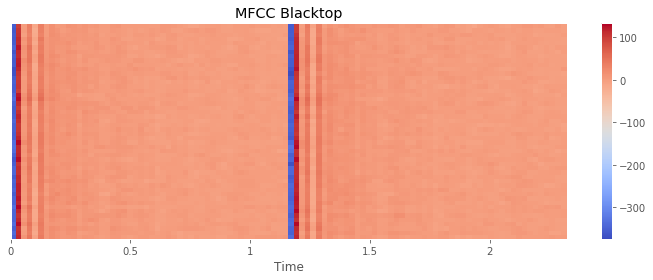

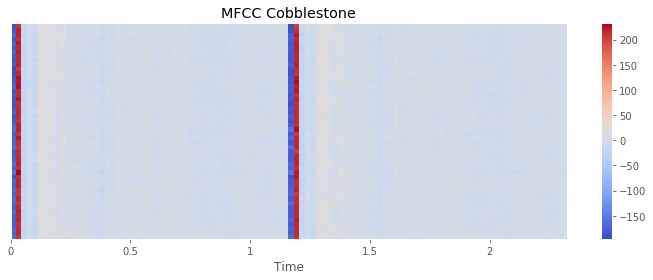

In [5]:
parent_dir = 'trainset'
tr_sub_dirs = ['blacktop','cobblestone']
tr_features,tr_labels = extract_features(parent_dir,tr_sub_dirs)
tr_labels = one_hot_encode(tr_labels)

plt.figure(figsize=(10, 4))
librosa.display.specshow(tr_features[10], x_axis='time')
plt.colorbar()
plt.title('MFCC Blacktop')
plt.tight_layout()

plt.figure(figsize=(10, 4))
librosa.display.specshow(tr_features[len(tr_features)-10], x_axis='time')
plt.colorbar()
plt.title('MFCC Cobblestone')
plt.tight_layout()

s = np.arange(tr_features.shape[0])
np.random.shuffle(s)
tr_features = tr_features[s]
tr_labels = tr_labels[s]

 Mel-frequency cepstral coefficients graphs

In [6]:
def RNN(x, weight, bias):
    cell = rnn_cell.LSTMCell(n_hidden,state_is_tuple = True)
    cell = rnn_cell.MultiRNNCell([cell])
    output, state = tf.nn.dynamic_rnn(cell, x, dtype = tf.float32)
    output = tf.transpose(output, [1, 0, 2])
    last = tf.gather(output, int(output.get_shape()[0]) - 1)
    return tf.nn.softmax(tf.matmul(last, weight) + bias)

prediction = RNN(x, weight, bias)

In [7]:
# Define loss and optimizer
loss_f = -tf.reduce_sum(y * tf.log(prediction))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss_f)

# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

/Users/malamen/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [1]:
#train function
def train_model(output='model/small/model_small.ckt'):
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        
        for itr in range(training_iters):    
            offset = (itr * batch_size) % (tr_labels.shape[0] - batch_size)
            batch_x = tr_features[offset:(offset + batch_size), :, :]
            batch_y = tr_labels[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss_f],feed_dict={x: batch_x, y : batch_y})
                
            if itr % display_step == 0:
                # Calculate batch accuracy

                acc = session.run(accuracy, feed_dict={x: batch_x, y: batch_y})
                # Calculate batch loss
                loss = session.run(loss_f, feed_dict={x: batch_x, y: batch_y})
                print ("Iter " + str(itr) + ", Minibatch Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        tf.argmax(prediction, 1, name="predd")
        print('Test accuracy: ',round(session.run(accuracy, feed_dict={x: tr_features, y: tr_labels}) , 3))
        saver = tf.train.Saver()
        saver.save(session, output)

In [2]:
train_model('model/small/model_small_2.ckt')

NameError: name 'tf' is not defined